# Reservoir timeseries
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 28-07-2023<br>

**Introduction:**<br>


In [46]:
import os
import glob
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
# import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from shapely.geometry import Point
from tqdm import tqdm_notebook

In [2]:
# paths
path_datasets = 'E:/casadje/jrcbox/datasets/'
path_out = '../results/reservoirs/timeseries/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

## ReGeom

In [6]:
# load summary table
regeom = pd.read_excel(f'{path_datasets}reservoirs/ReGeom/ReGeomData_WOW_V1.xlsx', index_col='GRAND_ID')

regeom.head()

,RES_NAME,DAM_NAME,COUNTRY,shape,DAM_H_m,Mean_L_km,Mean_W_km,V_error,Ar_error,coeff_v,coeff_a,V_est_mcm,A_est_skm,V_diff_mcm,A_diff_skm,Longitude,Latitude,V_GRanD_mcm,A_GRanD_skm,Remark
GRAND_ID,,,,,,,,,,,,,,,,,,,,
1,,Terror Lake,United States,Elliptical Bowl,59,4.1,1.0,24.8,54.9,1.07,1.03,97.40,2.99,33.09,-1.15,-153.027083,57.651250,133.2,2.1,NaN
2,,Mayo,Canada,Parabolic Wedge,11,34.9,3.0,0.0,2.5,0.64,1.37,264.83,95.76,-0.05,-2.32,-135.362917,63.774583,264.8,92.5,Data updated from HydroLAKES
3,,Blue Lake,United States,Rectangular Prism,44,4.6,0.9,31.5,1.7,0.98,1.06,130.85,3.96,56.50,-0.08,-135.199583,57.066250,179.1,4.4,NaN
4,,Green Lake,United States,Elliptical Bowl,64,5.5,0.7,0.0,4.6,0.91,1.36,115.90,3.99,-0.05,-0.18,-135.110417,56.990417,115.9,3.9,NaN
5,Long Lake,Long Lake Dam,United States,Rectangular Prism,9,7.4,0.8,34.4,4.7,3.76,0.98,122.48,5.22,62.36,-0.25,-133.728750,58.170417,181.0,5.3,NaN


Let's see how the area-storage-depth curve for a given reservoir. I will look to the Lago Maggiore.

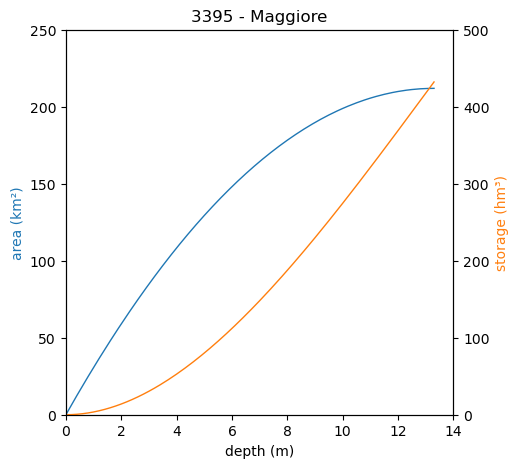

In [44]:
# GRanD ID of the reservoir
reservoir = 'Maggiore'
ID = regeom.loc[regeom.RES_NAME == reservoir].index[0]

# load the curve
asd = pd.read_csv(f'{path_datasets}reservoirs/ReGeom/Area_Str_Dp/{ID}.csv', skiprows=7)
asd.columns = asd.columns.str.strip()
asd.set_index('Depth(m)', drop=True, inplace=True)

# plot curve
fig, ax1 = plt.subplots(figsize=(5, 5))
# depth-area
ax1.plot(asd.index, asd['Area(skm)'], lw=1)
ax1.set(xlabel='depth (m)', xlim=(asd.index.min(), regeom.loc[ID, 'DAM_H_m']), ylim=(0, 250))
ax1.set_ylabel('area (km²)', color='C0')
ax1.set_title(f'{ID} - {reservoir}')
# depth-storage
ax2 = ax1.twinx()
ax2.plot(asd.index, asd['Storage(mcm)'], lw=1, c='C1')
ax2.set(ylim=(0, 500))
ax2.set_ylabel('storage (hm³)', color='C1');

It seems that **the depth of the reservoir is related to the dam height**. That might be true for artificial reservoirs, but not for controlled lakes like Lago Maggiore, whose depth exceeds 300 m. When the level of Lago Maggiore is just below the dam foundation, there's still plenty of water stored in the lake; this means that the curves above exagerate the reduction in area and volume with decreasing depth.

If we want to use altimetry data on these curves, the **depth must be converted into elevation**. The **elevation of the dam crest is needed** to do that conversion.

## ReaLSAT

In [47]:
realsat = gpd.read_file(f'{path_datasets}lakes/ReaLSAT/ReaLSAT-2-0/ReaLSAT.shp')

In [48]:
realsat.shape

(681137, 15)

In [50]:
realsat.head()

,ID,RESERVOIR,REL_DYN,CONTINENT,RIVR_SCORE,EPHM_SCORE,COMP_SCORE,Hylak_id,AREA,GRWL_1km,GRWL_4km,RES,BLON,BLAT,geometry
0,800005,-1,-1,2,-1.0,-1,-1.0,5,90907500.0,1,1,300,-90,40,"POLYGON ((-90.71849 46.65614, -90.71615 46.655..."
1,800006,-1,-1,2,-1.0,-1,-1.0,6,64121500.0,1,1,300,-90,40,"POLYGON ((-84.75366 45.83889, -84.75365 45.783..."
2,800007,-1,-1,2,-1.0,-1,-1.0,7,21475000.0,1,1,300,-80,40,"POLYGON ((-79.09597 43.81146, -79.09539 43.812..."
3,800008,-1,-1,2,-1.0,-1,-1.0,8,65989800.0,1,1,300,-90,40,"POLYGON ((-80.99597 45.92419, -80.99657 45.925..."
4,800009,-1,-1,2,-1.0,-1,-1.0,9,28611400.0,0,1,300,-90,40,"POLYGON ((-83.34595 41.88324, -83.34402 41.883..."


## DAHITI

## GRSAD